<p>
<h1><b><center></center></b></h1>
<center><img src="https://drive.google.com/uc?id=1UJc1ci41G6ahJ7ProKvunUOIBcTXZ6ZG" align="center" width="550"></center>
</p>
<h1><b><center>Mecánica Celeste</center></b></h1>
<h2><b><center>Prof. Jorge I. Zuluaga</center></b></h1>
<h2><b><center>Tarea 4</center></b><h2>
<h3><b><center>Transferencia bielíptica</center></b><h3>
<h5><center><b>Asignada</b>: 11 de noviembre de 2024</center><h5>
<h5><center><b>Entrega</b>: 25 de noviembre de 2024</center><h5>

<hr/>
<b>Nombre</b>: Simón Patiño
<br/>

<hr/>

## Enunciado

**Objetivo**: El objetivo de esta tarea es diseñar, usando las herramientas de optimización vistas en clase, una transferencia bielíptica.


**Procedimiento**:

Una extensión de la transferencia de Hohman se conoce como la transferencia *bi elíptica*. En esta transferencia se usan dos órbitas de transferencia elípticas, en lugar de una sola, para pasar de una órbita de partida $r_1$ a una de llegada $r_2$, tal que el apogeo de la primera es mayor que $r_2$ (exactamente igual a $r_i = s r_2$ donde $r_i$ se conoce como el *midcourse radius*) y el perigeo de la segunda coincide exactamente con $r_2$ (ver Figura 6.7 en Prussing).

Es posible probar que para valores de $R\equiv r_2/r_2\gg 10$ la transferencia bielíptica requiere delta-v menores que la transferencia de Hohmann.

1. Diseñe, con la rutina `mision_interplanetaria` una transferencia bielíptica entre la órbita de la Tierra ($r_1=1$) y la órbita de un cuerpo más allá de la órbita de Júpiter ($r_2=5$) o Saturno ($r_2 = 10$) con un $s$ dado.

  **Ayuda**: Como los impulsos se realizan solo en los apsides de las órbitas de transferencia, solo se necesitan 3 impulsos y todos dirigidos hacia el eje y.

2. Para un determinado valor de $r_2$ (entre 2 y 10) y de $s$ (entre 0 y 1.5) encuentre la órbita de transferencia bielíptica ótpima (menor delta-v total). Compare el delta-v total entre las órbitas con el requerido para una órbita de Hohmann. Grafique la órbita de transferencia resultante.

3. Aumente el valor de $r_2$ manteniendo $s$ constante ($s = 1.2, 1.3, 1.5$) y estudie lo que pasa con el detla-v total en la órbita de transferencia bielíptica y la órbita de Hohmann. Puede hacer por ejemplo un gráfico de delta-v total para transferencia de Hohmann y una para transferencia bielíptica, variando $r_2$ entre 5 y 16. ¿Para que valor de $r_2$ la órbita bielíptica es más óptima que la transferencia de Hohmann?.

**Atención**: En caso de utilizar ayudas como `ChatGPT` o códigos de `Stack Over Flow` debe citar debidamente la fuente, pero también entender a cabalidad el código, el profesor puede pedir justificación.

In [ ]:
#@title Herramientas requeridas
!pip install -Uq pymcel rebound
import rebound as rb
from rebound import units as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pymcel as pc
import spiceypy as spy

tau = 0
turnon = False

def aceleracion_impulso(simulacion):
    global tau,turnon

    if not turnon:
        return

    # Recuperar todos los datos de la simulación
    sim = simulacion.contents

    # Obtengo la partícula
    p = sim.particles[1]

    # Obtener las propiedades (pos, vel) de la partícula
    rvec = p.xyz
    urvec = rvec/np.linalg.norm(rvec)
    vvec = p.vxyz
    uvec = vvec/np.linalg.norm(vvec)

    # Thrust específico
    t = tau # km/s^2

    # Calculo la aceleración debida a la fuerza nueva
    tvec = t*uvec

    # Modifico la aceleración de la partícula
    p.ax += tvec[0]
    p.ay += tvec[1]
    p.az += tvec[2]

def mision_interplanetaria(m,units,orbita_inicial,maniobras):
    """Una rutina para el diseño de una misión interplanetaria

    Ejemplo:
        rms = mision_interplanetaria(
          m=1,
          units=('au','yr','Msun'),
          orbita_inicial=dict(a=1,e=0),
          maniobras=[
              dict(tipo='balistica',deltat=0.5,tunit='P',N=100),
              dict(tipo='impulsiva',deltav=np.array([+3,0,0])),
              dict(tipo='balistica',deltat=1,tunit='uc',N=100),
          ]
        )
    """
    global tau,turnon

    # Defino la simulación
    sim = rb.Simulation()
    sim.units = units
    sim.add(m=m)
    sim.add(m=0,**orbita_inicial)
    sim.additional_forces = aceleracion_impulso
    sim.force_is_velocity_dependent = True

    # Maniobras
    Xms = []
    Ems = []
    t = 0

    # Posición inicial
    o=sim.orbits()[0]
    Xs = [list(sim.particles[1].xyz)+list(sim.particles[1].vxyz)]
    Es = [[o.a,o.e,o.inc,o.omega,o.Omega,o.f,o.M,o.P]]
    Xms += [np.array(Xs)]
    Ems += [np.array(Es)]

    for maniobra in maniobras:
        if maniobra['tipo'] == 'balistica':
            P = sim.particles[1].P
            # Escoge las unidades de deltat
            if ('tunit' in maniobra.keys()) and maniobra['tunit']=='P':
              deltat = maniobra['deltat']*abs(P)
            else:
              deltat = maniobra['deltat']

            ts = np.linspace(t, t + deltat,
                             maniobra['N'])
            Xs = []
            Es = []
            for t in ts:
                sim.integrate(t)
                o=sim.orbits()[0]
                Xs += [list(sim.particles[1].xyz)+list(sim.particles[1].vxyz)]
                Es += [[o.a,o.e,o.inc,o.omega,o.Omega,o.f,o.M,o.P]]
            Xms += [np.array(Xs)]
            Ems += [np.array(Es)]

        elif maniobra['tipo'] == 'impulsiva':
            sim.particles[1].vxyz += maniobra['deltav']
            o=sim.orbits()[0]
            Xs = [list(sim.particles[1].xyz)+list(sim.particles[1].vxyz)]
            Es = [[o.a,o.e,o.inc,o.omega,o.Omega,o.f,o.M,o.P]]
            Xms += [np.array(Xs)]
            Ems += [np.array(Es)]

        elif maniobra['tipo'] == 'noimpulsiva':
            P = sim.particles[1].P
            # Escoge las unidades de deltat
            if ('tunit' in maniobra.keys()) and maniobra['tunit']=='P':
              deltat = maniobra['deltat']*abs(P)
            else:
              deltat = maniobra['deltat']

            deltat = maniobra['deltat'] if maniobra['deltat']>=0 else -maniobra['deltat']*P
            tau = maniobra['tau']
            turnon = True
            ts = np.linspace(t, t + deltat,
                             maniobra['N'])
            Xs = []
            Es = []
            for t in ts:
                sim.integrate(t)
                o=sim.orbits()[0]
                Xs += [list(sim.particles[1].xyz)+list(sim.particles[1].vxyz)]
                Es += [[o.a,o.e,o.inc,o.omega,o.Omega,o.f,o.M,o.P]]
            Xms += [np.array(Xs)]
            Ems += [np.array(Es)]
            turnon = False

        else:
            raise Exception('Tipo de maniobra no reconocido')

    return Xms,Ems

def plot_mision(Xms):
  fig = plt.figure()
  ax = fig.add_subplot(111)

  ax.plot(Xms[0][0,0],Xms[0][0,1],'ko',ms=5,label=f'Ini.')
  n = 1
  ia = 1
  for i,rs in enumerate(Xms[1:]):
    ms = 0 if len(rs)>1 else 5

    if len(rs)==1:
      deltav = Xms[i+1][0,3:]-Xms[i][-1,3:]
      ax.plot(rs[:,0],rs[:,1],'v',ms=5)
      ax.quiver(rs[:,0],rs[:,1],deltav[0],deltav[1],label=f'Imp. {n}')
      n += 1
    else:
      ax.plot(rs[:,0],rs[:,1],'-',label=f'Arc.{ia}')
      ia += 1

  ax.plot(0,0,'o')
  ax.set_xlabel('x [uc]')
  ax.set_ylabel('y [uc]')
  ax.legend(loc='upper center',bbox_to_anchor=(0.5,1.1),ncol=8,fontsize=6)
  ax.axis('equal')
  return fig,ax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 785.3/785.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 9.6 MB/s eta 0:00:00
Paquete pymcel cargado. Versión: 0.6.13


## Solución

##*Goal 1*

##*If we want to make a Bi-Elliptical transfer, we need to execute 3 impulses. Also, it is very important to notice that the transfer orbits always need to be develop in  $\ 0.5P$ and only they have a velocity component  in $y$*

##*Random Test*

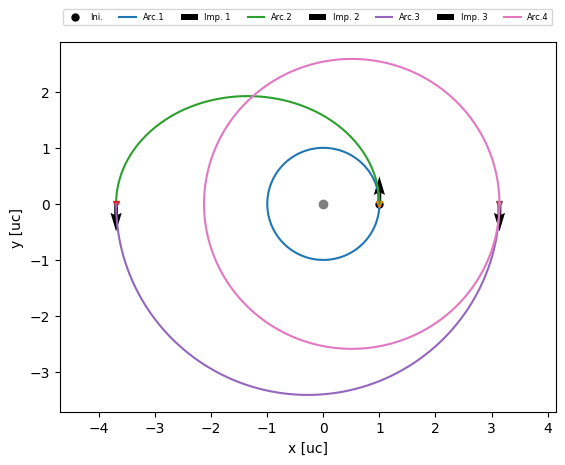

In [ ]:
# 1) Definiciones básicas
units = ('au','yr','msun')
m = 1
mu = u.convert_G(units)*m

r1 = 1 # Tierra
r2 = 10 # Saturno
s = 1.5
ri = r2*s

# 2) Crear una rutina que ejecute la misión
def mision_bieliptica(Y,N=2):
  global m,units,r1
  deltav1x,deltav1y,deltav2x,deltav2y,deltav3x,deltav3y,tflight = Y
  Xms,Ems = mision_interplanetaria(
    m=m,
    units=units,
    orbita_inicial=dict(a=r1,e=0),
    maniobras=[
        dict(tipo='balistica',deltat=1,tunit='P',N=N), # Orbita de transferencia
        dict(tipo='impulsiva',deltav=np.array([deltav1x,deltav1y,0])), # Impulso
        dict(tipo='balistica',deltat=tflight,tunit='P',N=N), # Orbita de transferencia
        dict(tipo='impulsiva',deltav=np.array([deltav2x,deltav2y,0])), # Impulso
        dict(tipo='balistica',deltat=tflight,tunit='P',N=N), # Orbita de transferencia
        dict(tipo='impulsiva',deltav=np.array([deltav3x,deltav3y,0])), # Impulso
        dict(tipo='balistica',deltat=1,tunit='P',N=N), # Orbita de transferencia
    ]
  )
  return Xms,Ems

# 3) De qué depende la función de costo:
# Dependerá: deltav1, deltav2, deltav3 , tflight = 0.5

# 4) Haga la prueba
Xms,Ems = mision_bieliptica([0,1.6,0,-1,0,-0.5,0.5],N=1000)
plot_mision(Xms);

##*Restrictions*



##*1.The final position of the spaceship after make the first impulse should be equal to $r_i$*
   
\\

##*2.The final position of the spaceship after make the second impulse should be equal to $r_2$*

\\

##*3.The eccentricity of the final orbit must be 0*

\\

##*4. The magnitude of the semi-axis $a$ of the second transfer orbit must be equal to $\frac{r_2 + r_i}{2}$*


In [ ]:
def funcion_costo(Y):

  deltav1x,deltav1y,deltav2x,deltav2y,deltav3x,deltav3y,tflight = Y
  fun = (deltav1x**2 + deltav1y**2)**0.5 + (deltav2x**2 + deltav2y**2)**0.5 + (deltav3x**2 + deltav3y**2)**0.5
  return fun

def restriccion_posicion(Y):
  global ri

  # Esta restricción dice que: ri (posición final de la trayectoria de transferencia) = ri
  Xms,Ems = mision_bieliptica(Y)
  rf = Xms[4][0,:3] # Posición final de la trayectoria de transferencia
  rf_mag = np.linalg.norm(rf)
  # Condicion: rf_mag = r2 -> rf_mag - r2 = 0
  E = ri - rf_mag
  return E

def restriccion_posicion_segunda(Y):
  global r2

  # Esta restricción dice que: r2 (posición final de la trayectoria de transferencia) = r2
  Xms,Ems = mision_bieliptica(Y)
  rf = Xms[6][0,:3] # Posición final de la trayectoria de transferencia
  rf_mag = np.linalg.norm(rf)
  # Condicion: rf_mag = r2 -> rf_mag - r2 = 0
  E = r2 - rf_mag
  return E

def restriccion_excentricidad(Y):
  # Esta restricción dice que: la órbita final tiene que tener excentricidad = 0
  Xms,Ems = mision_bieliptica(Y)
  # Elementos: 0:a, 1:e, 2:i, 3:omega, 4:Omega, 5:f, 6:M, 7:P
  ef = Ems[-1][-1,1] # Posición final de la trayectoria de transferencia
  E = ef
  return E

def restriccion_a(Y):
  global ri, r2

  a2 = (ri + r2)/2
  # Esta restricción dice que: la órbita final tiene que tener semieje mayor = ri +r2
  Xms,Ems = mision_bieliptica(Y)
  # Elementos: 0:a, 1:e, 2:i, 3:omega, 4:Omega, 5:f, 6:M, 7:P
  af = Ems[5][-1,0] # Posición final de la trayectoria de transferencia
  E = af - a2
  return E

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.270854080264403
       x: [ 0.000e+00  2.063e+00  0.000e+00 -9.392e-01  0.000e+00
           -2.682e-01  5.000e-01]
     nit: 19
     jac: [       nan  1.000e+00        nan -1.000e+00        nan
           -1.000e+00  0.000e+00]
    nfev: 98
    njev: 19


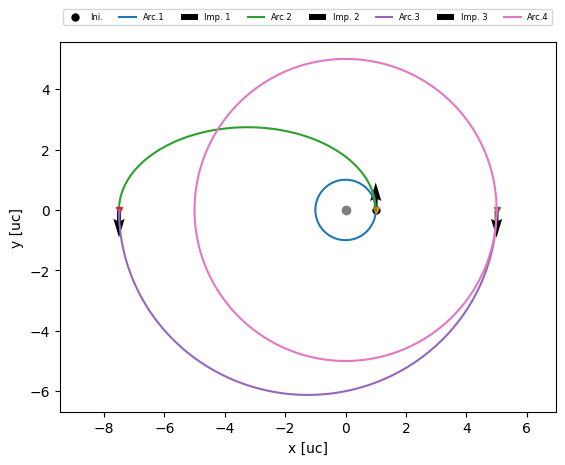

In [ ]:
r2 = 5
s = 1.5
ri = r2*s

Yguess = [0,1,0,-1,0.0,-1,0.5]
solucion = minimize(
    funcion_costo,
    Yguess,
    constraints=[
        dict(type='eq',fun=restriccion_posicion),
        dict(type='eq',fun=restriccion_posicion_segunda),
        dict(type='eq',fun=restriccion_excentricidad),
        dict(type='eq',fun=restriccion_a)
    ],
    options=dict(maxiter=1000),
    bounds=[
        (0,0),
        (None,None),
        (0,0),
        (None,None),
        (0,0),
        (None,None),
        (0,1)
    ]
)
print(solucion)

Xms,Ems = mision_bieliptica(solucion.x,N=1000)
plot_mision(Xms);

##*Goal 2*

##*For*

$$
s = 1.5 \\
r_1 = 1 \ au\\
r_2 = 10 \ au
$$

##*Optimal Bi-Elliptic Transfer*

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.387463727314293
       x: [ 0.000e+00  2.320e+00  0.000e+00 -8.774e-01  0.000e+00
           -1.896e-01  5.000e-01]
     nit: 18
     jac: [       nan  1.000e+00        nan -1.000e+00        nan
           -1.000e+00  0.000e+00]
    nfev: 99
    njev: 18


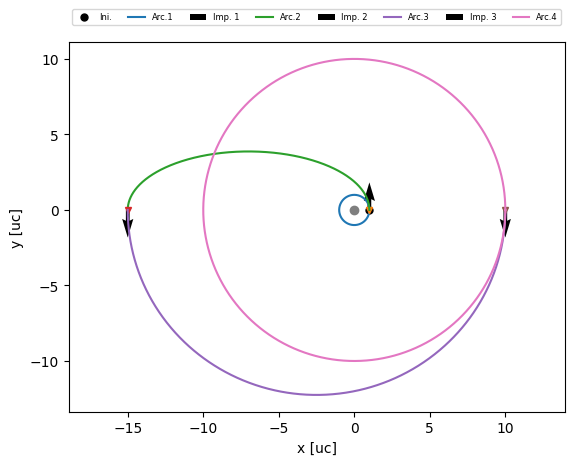

In [ ]:
r1 = 1
r2 = 10
s = 1.5
ri = r2*s

Yguess = [0,1,0,-1,0.0,-1,0.5]
solucion = minimize(
    funcion_costo,
    Yguess,
    constraints=[
        dict(type='eq',fun=restriccion_posicion),
        dict(type='eq',fun=restriccion_posicion_segunda),
        dict(type='eq',fun=restriccion_excentricidad),
        dict(type='eq',fun=restriccion_a)
    ],
    options=dict(maxiter=1000),
    bounds=[
        (0,0),
        (None,None),
        (0,0),
        (None,None),
        (0,0),
        (None,None),
        (0,1)
    ]
)
print(solucion)

Xms,Ems = mision_bieliptica(solucion.x,N=1000)
plot_mision(Xms);

$\Delta V = 3.3874 \ au/yrs$

##*Hohmann Transfer Orbit*

In [ ]:
# 2) Crear una rutina que ejecute la misión
def mision_hohmann(Y,N=2):
  global m,r1,r2
  deltav1x,deltav1y,deltav2x,deltav2y,tflight = Y
  Xms,Ems = mision_interplanetaria(
    m=m,
    units=units,
    orbita_inicial=dict(a=r1,e=0),
    maniobras=[
        dict(tipo='balistica',deltat=1,tunit='P',N=N), # Orbita de transferencia
        dict(tipo='impulsiva',deltav=np.array([deltav1x,deltav1y,0])), # Impulso
        dict(tipo='balistica',deltat=tflight,tunit='P',N=N), # Orbita de transferencia
        dict(tipo='impulsiva',deltav=np.array([deltav2x,deltav2y,0])), # Impulso
        dict(tipo='balistica',deltat=1,tunit='P',N=N), # Orbita de transferencia
    ]
  )
  return Xms,Ems

# 3) De qué depende la función de costo:
# Dependerá: deltav1, deltav2

def funcion_costo_h(Y):
  deltav1x,deltav1y,deltav2x,deltav2y,tflight = Y
  fun = (deltav1x**2 + deltav1y**2)**0.5 + (deltav2x**2 + deltav2y**2)**0.5
  return fun

def restriccion_posicion_h(Y):
  global r2
  # Esta restricción dice que: r2 (posición final de la trayectoria de transferencia) = r2
  Xms,Ems = mision_hohmann(Y)
  rf = Xms[-1][0,:3] # Posición final de la trayectoria de transferencia
  rf_mag = np.linalg.norm(rf)
  # Condicion: rf_mag = r2 -> rf_mag - r2 = 0
  E = rf_mag - r2
  return E

def restriccion_excentricidad_h(Y):
  # Esta restricción dice que: la órbita final tiene que tener excentricidad = 0
  Xms,Ems = mision_hohmann(Y)
  # Elementos: 0:a, 1:e, 2:i, 3:omega, 4:Omega, 5:f, 6:M, 7:P
  ef = Ems[-1][-1,1] # Posición final de la trayectoria de transferencia
  E = ef
  return E


##*Optimal Hohmann Transfer*

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.3286899147295257
       x: [ 3.999e-04  2.189e+00  4.976e-04 -1.140e+00  4.998e-01]
     nit: 99
     jac: [ 1.830e-04  1.000e+00  4.363e-04 -1.000e+00  0.000e+00]
    nfev: 1181
    njev: 99


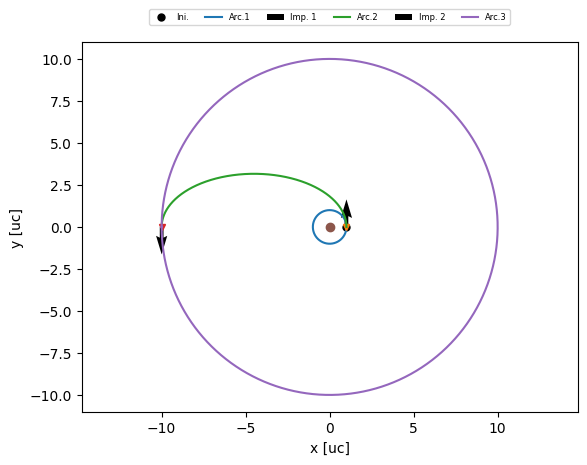

In [ ]:
Yguess_h = [0,1,0,1,0.3]
solucion = minimize(
    funcion_costo_h,
    Yguess_h,
    constraints=[
        dict(type='eq',fun=restriccion_posicion_h),
        dict(type='eq',fun=restriccion_excentricidad_h),
    ],
    options=dict(maxiter=200),
    bounds=[
        (None,None),
        (None,None),
        (None,None),
        (None,None),
        (0,1),
    ]
)
print(solucion)

Xms,Ems = mision_hohmann(solucion.x,N=1000)
plot_mision(Xms);

$\Delta V = 3.3286 \ au/yrs$

---
##*For these outcomes, we can conclude that for the values of $r_1, r_2$ and $s$ chosen, the Hohmann transfer require less $\Delta V$ (  Bi-Elliptic Transfer is 1.76 \% bigger)*

##*Our $R$ =  $\frac{r_2}{r_1} = \frac{10}{1} = 10 $*

\

##*In Prusing book, it says:*

\\

##"For  1 < $R$ < 11.94, the absolute minimum-fuel transfer is the Hohmann transfer"

\

##*That mean that our result make sense!*

##*Goal 3*

In [ ]:
r2s = np.linspace( 5, 16, 30) # list of r2

r2s

array([ 5.        ,  5.37931034,  5.75862069,  6.13793103,  6.51724138,
        6.89655172,  7.27586207,  7.65517241,  8.03448276,  8.4137931 ,
        8.79310345,  9.17241379,  9.55172414,  9.93103448, 10.31034483,
       10.68965517, 11.06896552, 11.44827586, 11.82758621, 12.20689655,
       12.5862069 , 12.96551724, 13.34482759, 13.72413793, 14.10344828,
       14.48275862, 14.86206897, 15.24137931, 15.62068966, 16.        ])

##*Let's calculate the varation between a greater $r_2$ and the requiered $\Delta V$ in the Bi-Elliptical transfer*

For $S=1.5$

In [ ]:
s = 1.5

Yguess = [0,2.1,0,0.92,0.0,-0.1,0.5]

deltavs_bi = [0]*len(r2s)

for i,r2 in enumerate(r2s):

  ri = r2*s

  solucion = minimize(
      funcion_costo,
      Yguess,
      constraints=[
          dict(type='eq',fun=restriccion_posicion),
          dict(type='eq',fun=restriccion_posicion_segunda),
          dict(type='eq',fun=restriccion_excentricidad),
          dict(type='eq',fun=restriccion_a)
      ],
      options=dict(maxiter=1000),
      bounds=[
          (0,0),
          (None,None),
          (0,0),
          (None,None),
          (0,0),
          (None,None),
          (0,1)
      ]
  )

  deltavs_bi[i] = solucion.fun

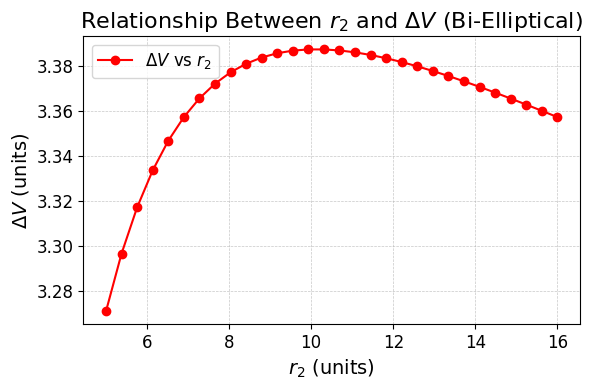

In [ ]:
# Create the plot
plt.figure(figsize=(6, 4))
plt.plot(r2s, deltavs_bi, label=r"$\Delta V$ vs $r_2$", color="red", linewidth=1.5 , marker = "o")

# Set axis labels with LaTeX
plt.xlabel(r"$r_2$ (units)", fontsize=14)
plt.ylabel(r"$\Delta V$ (units)", fontsize=14)

# Add grid, legend, and title
plt.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc="upper left")
plt.title("Relationship Between $r_2$ and $\Delta V$ (Bi-Elliptical)", fontsize=16)

# Set ticks with scientific journal-like style
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Tight layout for better spacing
plt.tight_layout()

# Save or show the plot
plt.savefig("delta_v_vs_r2.png", dpi=300)  # Save as high-resolution image
plt.show()

##*Biggers $r_2$ not necessary induce to biggers $\Delta V$*

##*Let's calculate the varation between a greater $r_2$ and the required $\Delta V$ in the Hohmann transfer*

In [ ]:
Yguess_h = [0,2.1,0,-1,0.5]

deltavs_hohmann = [0]*len(r2s)

for i,r2 in enumerate(r2s):

  solucion_h = minimize(
      funcion_costo_h,
      Yguess_h,
      constraints=[
          dict(type='eq',fun=restriccion_posicion_h),
          dict(type='eq',fun=restriccion_excentricidad_h),
      ],
      options=dict(maxiter=200),
      bounds=[
          (None,None),
          (None,None),
          (None,None),
          (None,None),
          (0,1),
      ]
  )

  deltavs_hohmann[i] = solucion_h.fun


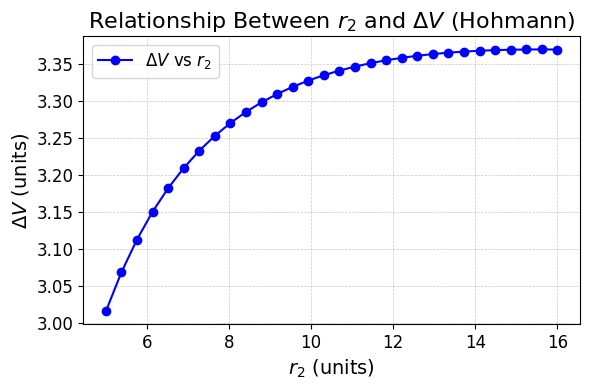

In [ ]:
# Create the plot
plt.figure(figsize=(6, 4))
plt.plot(r2s, deltavs_hohmann, label=r"$\Delta V$ vs $r_2$", color="blue", linewidth=1.5 , marker = "o")

# Set axis labels with LaTeX
plt.xlabel(r"$r_2$ (units)", fontsize=14)
plt.ylabel(r"$\Delta V$ (units)", fontsize=14)

# Add grid, legend, and title
plt.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc="upper left")
plt.title("Relationship Between $r_2$ and $\Delta V$ (Hohmann)", fontsize=16)

# Set ticks with scientific journal-like style
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Tight layout for better spacing
plt.tight_layout()

# Save or show the plot
plt.savefig("delta_v_vs_r2.png", dpi=300)  # Save as high-resolution image
plt.show()

##*Biggers $r_2$ induce to biggers $\Delta V$*

##*Let's compare them*

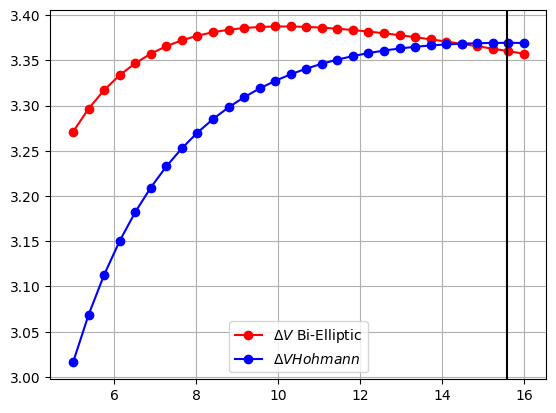

In [ ]:
plt.plot(r2s, deltavs_bi, label=r"$\Delta V$ Bi-Elliptic", color="red", linewidth=1.5 , marker = "o")
plt.plot(r2s, deltavs_hohmann, label=r"$\Delta V Hohmann$", color="blue", linewidth=1.5, marker = "o")
plt.axvline(15.58, color="k")
plt.legend()
plt.grid()
plt.show()

For $S = 1.3$

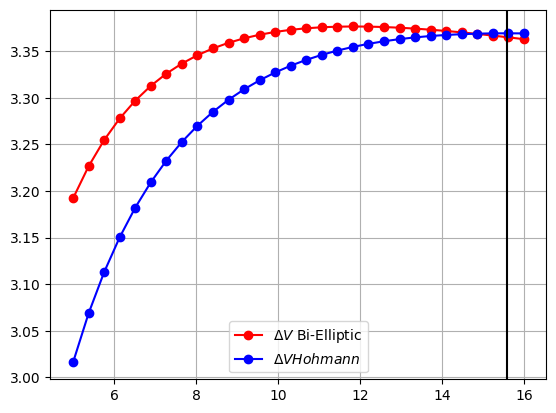

In [ ]:
s = 1.3

Yguess = [0,2,0,-0.92,0.0,-0.1,0.5]

deltavs_bi_2 = [0]*len(r2s)

for i,r2 in enumerate(r2s):

  ri = r2*s

  solucion = minimize(
      funcion_costo,
      Yguess,
      constraints=[
          dict(type='eq',fun=restriccion_posicion),
          dict(type='eq',fun=restriccion_posicion_segunda),
          dict(type='eq',fun=restriccion_excentricidad),
          dict(type='eq',fun=restriccion_a)
      ],
      options=dict(maxiter=1000),
      bounds=[
          (0,0),
          (None,None),
          (0,0),
          (None,None),
          (0,0),
          (None,None),
          (0,1)
      ]
  )

  deltavs_bi_2[i] = solucion.fun


plt.plot(r2s, deltavs_bi_2, label=r"$\Delta V$ Bi-Elliptic", color="red", linewidth=1.5 , marker = "o")
plt.plot(r2s, deltavs_hohmann, label=r"$\Delta V Hohmann$", color="blue", linewidth=1.5, marker = "o")
plt.axvline(15.58, color="k")
plt.legend()
plt.grid()
plt.show()

For $S = 1.2$

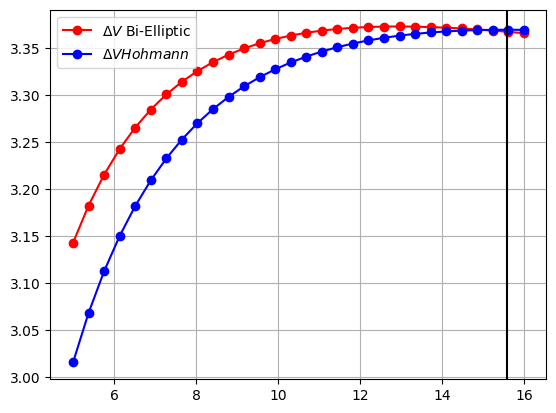

In [ ]:
s = 1.2

Yguess = [0,2.1,0,-0.92,0.0,-0.1,0.5]

deltavs_bi_3 = [0]*len(r2s)

for i,r2 in enumerate(r2s):

  ri = r2*s

  solucion = minimize(
      funcion_costo,
      Yguess,
      constraints=[
          dict(type='eq',fun=restriccion_posicion),
          dict(type='eq',fun=restriccion_posicion_segunda),
          dict(type='eq',fun=restriccion_excentricidad),
          dict(type='eq',fun=restriccion_a)
      ],
      options=dict(maxiter=1000),
      bounds=[
          (0,0),
          (None,None),
          (0,0),
          (None,None),
          (0,0),
          (None,None),
          (0,1)
      ]
  )

  deltavs_bi_3[i] = solucion.fun


plt.plot(r2s, deltavs_bi_3, label=r"$\Delta V$ Bi-Elliptic", color="red", linewidth=1.5 , marker = "o")
plt.plot(r2s, deltavs_hohmann, label=r"$\Delta V Hohmann$", color="blue", linewidth=1.5, marker = "o")
plt.axvline(15.58, color="k")
plt.legend()
plt.grid()
plt.show()

#*Conclusions:*

##*Around $R \approx 15 $ ($r_2 = 15$ ) the Bi-Elliptical transfer required a fewer $\Delta V$. This corresponds with the theory develop in the Prussing book:*

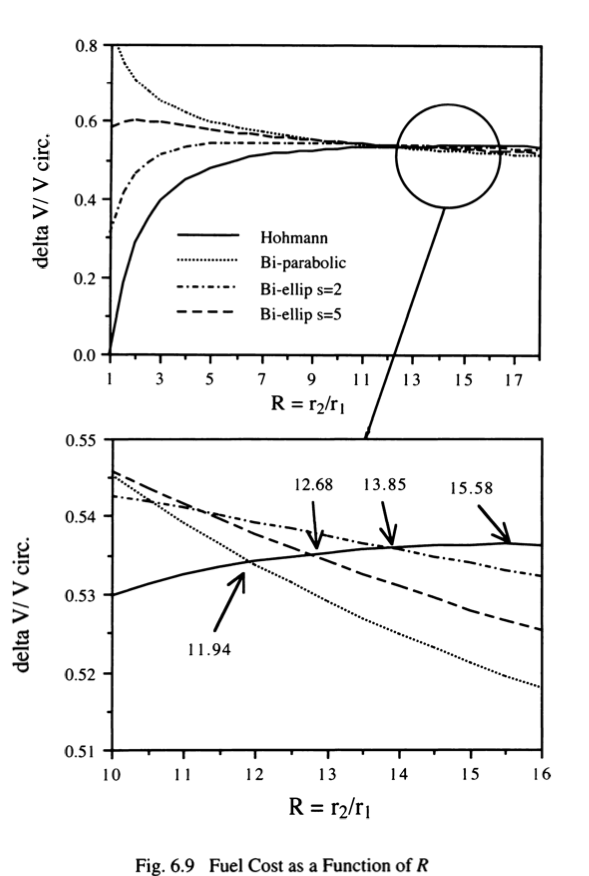

##*For any $R$ > $15.58$ the Bi-Elliptical transfer require less $\Delta V$ than a Hohmann transfer.*


##*Between 11.94 < $R$ < 15.58, Bi-Elliptical transfer is more economical only  for some values of $s$ > $s_{min}$*

##*Notice that a bigger $s$ generate a more efficient Bi-Elliptical transfer*